<a href="https://colab.research.google.com/github/amura/Deploying-deep-learning-model-to-web-and-mobile/blob/main/Deploying_deep_learning_model_on_web_and_mobile_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dependencies

In [ ]:
import pandas as pd
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib




Download training set




In [ ]:
data_source = "https://lp-prod-resources.s3-us-west-2.amazonaws.com/other/Deploying+a+Deep+Learning+Model+on+Web+and+Mobile+Applications+Using+TensorFlow/Food+101+-+Data+Subset.zip"
tf.keras.utils.get_file("food-101", data_source, untar=True)



153668842/153668842 [==============================] - 11s 0us/step


'/root/.keras/datasets/food-101'

In [ ]:
!ls /root/.keras/datasets/ -la

total 150076
drwxr-xr-x 2 root root      4096 Mar 19 21:20 .
drwxr-xr-x 1 root root      4096 Mar 19 21:20 ..
-rw-r--r-- 1 root root 153668842 Mar 19 21:20 food-101.tar.gz


In [ ]:
!unzip /root/.keras/datasets/food-101.tar.gz -d ./food-101



Streaming output truncated to the last 5000 lines.
  inflating: ./food-101/food-101-subset/images/falafel/3313716.jpg  
  inflating: ./food-101/__MACOSX/food-101-subset/images/falafel/._3313716.jpg  
  inflating: ./food-101/food-101-subset/images/falafel/1639203.jpg  
  inflating: ./food-101/__MACOSX/food-101-subset/images/falafel/._1639203.jpg  
  inflating: ./food-101/food-101-subset/images/falafel/3872274.jpg  
  inflating: ./food-101/__MACOSX/food-101-subset/images/falafel/._3872274.jpg  
  inflating: ./food-101/food-101-subset/images/falafel/3334395.jpg  
  inflating: ./food-101/__MACOSX/food-101-subset/images/falafel/._3334395.jpg  
  inflating: ./food-101/food-101-subset/images/falafel/514345.jpg  
  inflating: ./food-101/__MACOSX/food-101-subset/images/falafel/._514345.jpg  
  inflating: ./food-101/food-101-subset/images/falafel/1965617.jpg  
  inflating: ./food-101/__MACOSX/food-101-subset/images/falafel/._1965617.jpg  
  inflating: ./food-101/food-101-subset/images/falafel/21

Review image data

In [ ]:

data_dir = pathlib.Path('./food-101/food-101-subset')
print(data_dir)


food-101/food-101-subset


In [ ]:
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

3000


# Explorer data


Read in the images and then split the data into training and validation using ImageDataGenerator. Only filtered down to five classes for performance reasons.


In [ ]:
batch_size = 32
img_height = 224
img_width = 224
# use image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., validation_split=0.2, 
                                                                rotation_range = 40, width_shift_range = 0.2, 
                                                                height_shift_range = 0.2, shear_range = 0.2, 
                                                                zoom_range = 0.2, horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
    classes=["apple_pie", "caesar_salad", "falafel"],
     directory=pathlib.Path(data_dir, "images"),  
     class_mode="categorical" ,
    subset="training",
    target_size=(img_height, img_width),
    batch_size=batch_size  
)

validation_generator = train_datagen.flow_from_directory(
     classes=["apple_pie", "caesar_salad", "falafel"],
     directory=pathlib.Path(data_dir, "images"),
     class_mode="categorical" ,
    subset="validation",
    target_size=(img_height, img_width),
    batch_size=batch_size  
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
ALL_DATA_DIR = pathlib.Path(str(data_dir) + "/images")
ALL_CLASS_NAMES = sorted(np.array([item.name for item in ALL_DATA_DIR.glob('*') if item.name != '.DS_Store']))

print(ALL_CLASS_NAMES)

['apple_pie', 'caesar_salad', 'falafel']


In [ ]:
# save class labels
with open(f"classes.json",'w') as f:
  json.dump(ALL_CLASS_NAMES,f)

# Training using Keras models
## VGG19
Create a VGG19 instance. Exclude the top dense classifier, as this will be replaced later on.

In [ ]:
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet', include_top = False, input_shape=(img_width,img_height, 3))

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
#summary
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Feature extraction by adding dense classifier

In [ ]:
from keras import models
from keras import layers

model = models.Sequential([
  conv_base,
  layers.GlobalAveragePooling2D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(3, activation='softmax')                             
])

Freeze the base conv base layer and then compile the model

In [ ]:
from keras import optimizers
conv_base.trainable = False
print("number trainable weights", len(model.trainable_weights))
#compile
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-3), metrics=['acc'])

number trainable weights 4


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                8208      
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 20,032,643
Trainable params: 8,259
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
from keras import callbacks
import time
# utility class for accumulating the training time
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
     

Fit the model

In [ ]:
num_epochs = 3
time_callback = TimeHistory()
history = model.fit( train_generator, epochs=num_epochs, batch_size=batch_size, validation_data=validation_generator, callbacks=[time_callback])
print("Timing summary", time_callback.times)

Epoch 1/3
75/75 [==============================] - 60s 781ms/step - loss: 0.9816 - acc: 0.5738 - val_loss: 0.8783 - val_acc: 0.6483
Epoch 2/3
75/75 [==============================] - 47s 621ms/step - loss: 0.8262 - acc: 0.6646 - val_loss: 0.7698 - val_acc: 0.6950
Epoch 3/3
75/75 [==============================] - 47s 622ms/step - loss: 0.7359 - acc: 0.6963 - val_loss: 0.7338 - val_acc: 0.6833
Timing summary [59.72861647605896, 46.533591747283936, 46.585174560546875]


keys {'loss': [0.9816439747810364, 0.8262032270431519, 0.7358729839324951], 'acc': [0.5737500190734863, 0.6645833253860474, 0.6962500214576721], 'val_loss': [0.878264844417572, 0.7697690725326538, 0.7337521314620972], 'val_acc': [0.6483333110809326, 0.6949999928474426, 0.6833333373069763]}


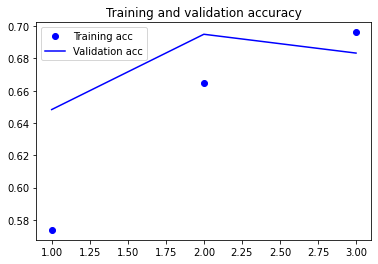

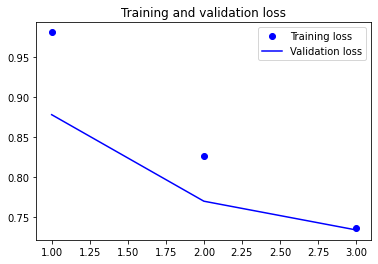

In [ ]:
acc = history.history['acc']
print("keys", history.history)
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Saving the model to disc


In [ ]:
!mkdir -p saved_model
model.save("saved_model/model_vgg19.h5")

# Training summary
Model: "VGG19"

* Total params: 20,032,677
* Trainable params: 8,293
* Non-trainable params: 20,024,384
* Training time 9565s
* Accuracy 64%
* Model size: 76.5Mb




# ResNet50

In [ ]:
from keras.applications import ResNet50

resnet_base_model =ResNet50(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
#freeze layers
resnet_base_model.trainable = False

In [ ]:
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Build and compile our model

In [ ]:
res_model = models.Sequential([
  resnet_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(3, activation='softmax')                             
])

In [ ]:
res_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 16)                32784     
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 23,620,547
Trainable params: 32,835
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
res_model.compile(optimizer=optimizers.RMSprop(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['acc'])


Fit the resnet model

In [ ]:
time_callback = TimeHistory()
res_history = res_model.fit(train_generator, epochs=num_epochs, batch_size=batch_size, validation_data=validation_generator, callbacks=[time_callback])
print("Timing summary", time_callback.times)

Epoch 1/3
75/75 [==============================] - 53s 664ms/step - loss: 1.1148 - acc: 0.3771 - val_loss: 1.0784 - val_acc: 0.3967
Epoch 2/3
75/75 [==============================] - 45s 604ms/step - loss: 1.0783 - acc: 0.4242 - val_loss: 1.0895 - val_acc: 0.4033
Epoch 3/3
75/75 [==============================] - 45s 601ms/step - loss: 1.0674 - acc: 0.4304 - val_loss: 1.1403 - val_acc: 0.3383
Timing summary [53.39403057098389, 45.212913274765015, 44.97032928466797]


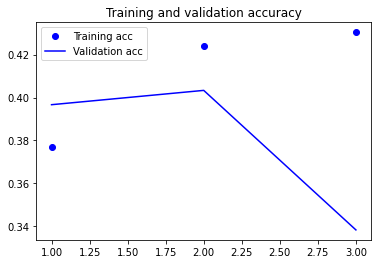

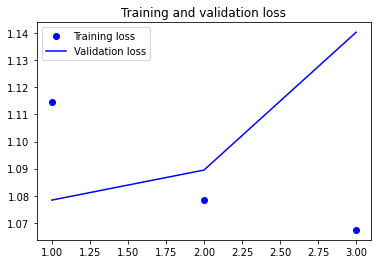

In [ ]:
acc = res_history.history['acc']
val_acc =res_history.history['val_acc']
loss = res_history.history['loss']
val_loss = res_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
res_model.save("saved_model/model_res.h5")

# Training summary
Model: "ResNet50"

* Total params: 23,620,581
* Trainable params: 32,869
* Non-trainable params: 23,587,712
* Training time 2,396s
* Accuracy 32%
* Model size: 94.3Mb




# MobileNetV2

In [ ]:
from keras.applications import MobileNetV2

mobile_base_model =MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")

In [ ]:
#freeze layers
mobile_base_model.trainable = False

In [ ]:
mobile_base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Build and compile our model

In [ ]:
mobile_model = models.Sequential([
  mobile_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(3, activation='softmax')                             
])

In [ ]:
# compile
mobile_model.compile(optimizer=optimizers.RMSprop(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
mobile_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 16)                20496     
                                                                 
 dense_7 (Dense)             (None, 3)                 51        
                                                                 
Total params: 2,278,531
Trainable params: 20,547
Non-trainable params: 2,257,984
_________________________________________________________________


Fit

In [ ]:
time_callback = TimeHistory()
mobile_history = mobile_model.fit(train_generator, epochs=num_epochs, batch_size=batch_size, validation_data=validation_generator, callbacks=[time_callback])
print("Timing summary", time_callback.times)

Epoch 1/3
75/75 [==============================] - 49s 606ms/step - loss: 0.5503 - acc: 0.7792 - val_loss: 0.3679 - val_acc: 0.8600
Epoch 2/3
75/75 [==============================] - 42s 562ms/step - loss: 0.3186 - acc: 0.8758 - val_loss: 0.3304 - val_acc: 0.8783
Epoch 3/3
75/75 [==============================] - 43s 576ms/step - loss: 0.2926 - acc: 0.8917 - val_loss: 0.2933 - val_acc: 0.9000
Timing summary [49.38963508605957, 42.01886606216431, 43.124205350875854]


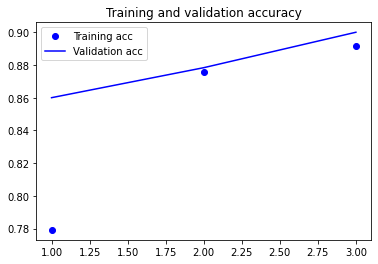

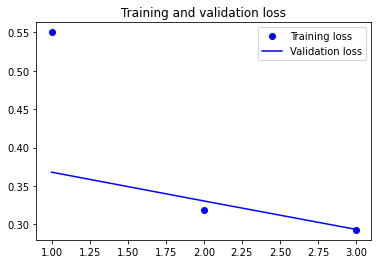

In [ ]:
acc = mobile_history.history['acc']
val_acc =mobile_history.history['val_acc']
loss = mobile_history.history['loss']
val_loss = mobile_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save("saved_model/model_mobile.h5")

In [ ]:
!pip install tensorflowjs==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 KB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h5py: filename=h5py-2.10.0-cp39-cp39-linux_x86_64.whl size=5730265 sha256=1c1b105befc555ebe005a2320b5187de8b41e1b9fe52d21eed7eda410616d13a
  Stored in directory: /root/.cache/pip/wheels/91/57/54/aa5901c840e89c1e931141d848b27421f68ad98bd285cc4036
Successfully built h5py
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.13.0
    Uninstalling tensorflow-hub-0.13.0:
      Successfully uninstalled tensorflow-hub-0.13.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.8.0
    Uninstalling h5py-3.8.0:
      Successfully uninstalled h5py-3.8

In [ ]:
!tensorflowjs_converter ./saved_model/model_res.h5 model_tfjs  --input_format keras --output_format tfjs_graph_model --weight_shard_size_bytes 50000000 --quantize_float16

2023-03-19 21:44:15.705375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-19 21:44:15.705486: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-19 21:44:15.705509: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-03-19 21:44:18.123962: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environme

# Training summary
Model: "MobileNet"

* Total params: 2,278,565
* Trainable params: 20,581
* Non-trainable params: 2,257,984
* Training time 698s
* Accuracy 87%
* Model size: 76.5Mb




# Summary

<table>
  <tr>
    <th>Model</th>
    <th>Trainable parameters</th>
    <th>Non trainable parameters</th>
    <th>Time (hh:mm:ss)</th>
    <th>Accuracy (%)</th>
    <th>Epochs</th>
    <th>Model size</th>
  </tr>
  <tr>
   <td>VGG19</td>
   <td>8,293</td>
   <td>20,024,384</td>
   <td>2:39:25</td>
   <td> 64</td>
   <td> 3</td>
   <td> 76.5</td>    
  </tr>
   <tr>
   <td>ResNet50</td>
   <td>32,869</td>
   <td>23,587,712</td>
   <td>0:39:55</td>
   <td> 32</td>
   <td> 3</td>
   <td> 94.3</td>    
  </tr>
    <tr>
   <td>MobileNetV2</td>
   <td>32,869</td>
   <td>23,587,712</td>
   <td>0:11:37</td>
   <td> 87</td>
   <td> 3</td>
   <td> 76.5</td>    
  </tr>
</table>

In [ ]:
# copy classes, and models filel to google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import shutil

pathToModels = '/content/gdrive/MyDrive/manning/food-deep-learning/'
shutil.copyfile('./saved_model/model_mobile.h5', pathToModels + 'mobile.h5')
shutil.copyfile('./classes.json', pathToModels + 'classes.json')
shutil.copy()

'/content/gdrive/MyDrive/manning/food-deep-learning/classes.json'

In [ ]:
from distutils.dir_util import copy_tree
copy_tree("./model_tfjs", pathToModels+'model_tfjs_2023')

['/content/gdrive/MyDrive/manning/food-deep-learning/model_tfjs_2023/model.json',
 '/content/gdrive/MyDrive/manning/food-deep-learning/model_tfjs_2023/group1-shard1of1.bin']